## Supplementary Figure - Dispatch Breakdown
Siobhan Powell, 2021.

In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import pickle

In [3]:
from simple_dispatch import bidStack
import matplotlib
import scipy
from future_grid import FutureDemand

In [4]:
unit_drops = pd.read_csv('IntermediateOutputs/scheduled_retirements_2019.csv', index_col=0)
additions_df = pd.read_csv('IntermediateOutputs/generator_additions.csv', index_col=0)
import copy
def drop_add_generators(future_year, gd_short_init, unit_drops=None, additions_df=None, drop=True, add=True):
    
    gd_short_final = copy.deepcopy(gd_short_init)
    if add:
        added_units = additions_df[additions_df['Year']<future_year]['orispl_unit'].values
        for i, val in enumerate(added_units):
            idx = len(gd_short_final.df)
            loc1 = gd_short_final.df[gd_short_final.df['orispl_unit']==val].index
            gd_short_final.df = pd.concat((gd_short_final.df, gd_short_final.df.loc[loc1]), ignore_index=True)
            gd_short_final.df.loc[idx, 'orispl_unit'] = 'added_'+str(i)
        
    if drop:
        dropped_units = unit_drops[unit_drops['retirement_year']<future_year]['orispl_unit'].values
        gd_short_final.df = gd_short_final.df[~gd_short_final.df['orispl_unit'].isin(dropped_units)].copy(deep=True).reset_index(drop=True)
    
    return gd_short_final

In [6]:
year = 2035; solar = 3.5; wind = 3; run_year=2019
gd_short = pickle.load(open('IntermediateOutputs/generator_data_short_%s_%s.obj'%('WECC', str(run_year)), 'rb'))
gd_short_copy = drop_add_generators(year, gd_short, drop=True, unit_drops=unit_drops, add=True, additions_df=additions_df)

# Plotting

In [7]:
def set_up_generator(year=2035, fuel=1.0, gd_short_copy=None):
    
    if gd_short_copy is not None:
        return gd_short_copy
    else:
        if year != 2019:
            gd_short_copy = drop_add_generators(year, gd_short, drop=True, unit_drops=unit_drops, add=True, additions_df=additions_df)
        else:
            gd_short_copy = copy.deepcopy(gd_short)
    
    return gd_short_copy

def set_up_scenario(year=2035, solar=3.5, wind=3, fuel=1.0, ev_pen=0.5, 
                    ev_scenario='BaseCase_NoL1', ev_timers='', ev_workplace_control='', 
                    ev_workplace_bool=False, evs_bool=True, ev_scenario_date='20220408', gd_short_copy=None):
    
    gd_short_copy = set_up_generator(year=year, fuel=fuel, gd_short_copy=gd_short_copy)
    future = FutureDemand(gd_short_copy, year=year)
    if year != 2019:
        future.electrification(scale_vs_given=True)
    future.solar_multiplier[year] = solar
    future.wind_multiplier[year] = wind
    future.solar()
    future.wind()
    
    if evs_bool:
        if ev_workplace_bool:
            future.evs(pen_level=ev_pen, scenario_name=ev_scenario, timers_extra_info=ev_timers, wp_control=ev_workplace_control, scenario_date=ev_scenario_date)
        else:
            future.evs(pen_level=ev_pen, scenario_name=ev_scenario, timers_extra_info=ev_timers, scenario_date=ev_scenario_date)
    
    future.update_total()
    
    return gd_short_copy, future

In [9]:
solar=3.5
wind=3
fuel=1
ev_scenario='BusinessAsUsual'
ev_timers=''
penlevel=0.5
ev_scenario_date='20220313'
gd_short_copy, future = set_up_scenario(year=2035, solar=solar, wind=wind, fuel=fuel, ev_scenario=ev_scenario, 
                                                                                ev_timers=ev_timers, ev_pen=penlevel, ev_workplace_control='minpeak', ev_workplace_bool=True, evs_bool=True, 
                                                                                gd_short_copy=None, ev_scenario_date=ev_scenario_date)
future.demand['demand'] = future.demand['demand'].clip(0, 1e10)
save_str = 'Results/Fuel1_Solar35_Wind3/fuel'+str(fuel)+'_solar'+str(solar)+'_wind'+str(wind)+'_'+ev_scenario+'_'+'TimersMixed'+'_WPcontrol_minpeak'+'_penlevel'+str(penlevel)+'_storagebefore'


In [10]:
storage_before = pd.read_csv(save_str+'_storagebeforedf_'+'20220408'+'.csv', index_col=0)
dpdf = pd.read_csv(save_str+'_withstorage_dpdf_'+'20220408'+'.csv')
test_dpdf = copy.deepcopy(dpdf)

In [11]:
dpdf.loc[200*24, 'datetime']

'2019-07-20 00:00:00'

In [12]:
pd.to_datetime(dpdf['datetime']).dt.weekday[199*24]

4

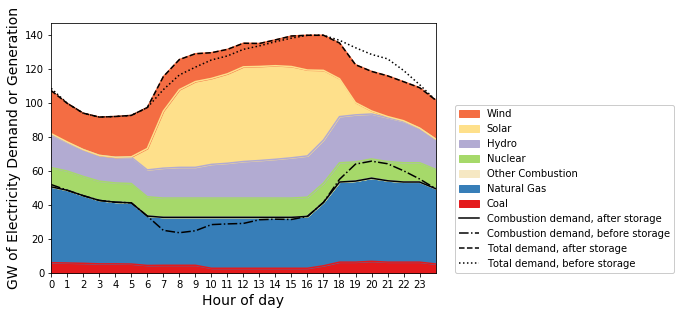

In [14]:
colors = ['#e41a1c', '#377eb8', '#f6e8c3', '#a6d96a', '#b2abd2', '#fee08b', '#f46d43']

test_dpdf = copy.deepcopy(dpdf)
test_storage = copy.deepcopy(storage_before)

solar_mult = 3.5
wind_mult = 3

inds = 199*24 + np.arange(0, 25)
xplot = np.arange(0, 25)

baseline = np.zeros((np.shape(inds)[0],))
plt.plot(xplot, (1/1000)*test_dpdf.loc[inds, 'coal_mix'], color=colors[0])
plt.fill_between(xplot, baseline, (1/1000)*test_dpdf.loc[inds, 'coal_mix'], color=colors[0], label='Coal')
baseline +=  (1/1000)*test_dpdf.loc[inds, 'coal_mix'].values
plt.plot(xplot, baseline + (1/1000)*test_dpdf.loc[inds, 'gas_mix'], color=colors[1])
plt.fill_between(xplot, baseline, baseline + (1/1000)*test_dpdf.loc[inds, 'gas_mix'], color=colors[1], label='Natural Gas')
baseline += (1/1000)*test_dpdf.loc[inds, 'gas_mix'].values
plt.plot(xplot, baseline + (1/1000)*test_dpdf.loc[inds, ['biomass_mix', 'oil_mix']].sum(axis=1), color=colors[2])
plt.fill_between(xplot, baseline, baseline + (1/1000)*test_dpdf.loc[inds, ['biomass_mix', 'oil_mix']].sum(axis=1), color=colors[2], label='Other Combustion')
baseline += (1/1000)*test_dpdf.loc[inds, ['biomass_mix', 'oil_mix']].sum(axis=1).values
plt.plot(xplot, baseline + (1/1000)*future.all_generation_2019.loc[inds, 'WECC_NUC'], color=colors[3])
plt.fill_between(xplot, baseline, baseline + (1/1000)*future.all_generation_2019.loc[inds, 'WECC_NUC'], color=colors[3], label='Nuclear')
baseline += (1/1000)*future.all_generation_2019.loc[inds, 'WECC_NUC'].values
plt.plot(xplot, baseline + (1/1000)*future.all_generation_2019.loc[inds, 'WECC_WAT'], color=colors[4])
plt.fill_between(xplot, baseline, baseline + (1/1000)*future.all_generation_2019.loc[inds, 'WECC_WAT'], color=colors[4], label='Hydro')
baseline += (1/1000)*future.all_generation_2019.loc[inds, 'WECC_WAT'].values

plt.plot(xplot, baseline + (solar_mult)*(1/1000)*future.all_generation_2019.loc[inds, 'WECC_SUN'], color=colors[5])
plt.fill_between(xplot, baseline, baseline + (solar_mult)*(1/1000)*future.all_generation_2019.loc[inds, 'WECC_SUN'], color=colors[5], label='Solar')
baseline += (solar_mult)*(1/1000)*future.all_generation_2019.loc[inds, 'WECC_SUN'].values

plt.plot(xplot, baseline + (wind_mult)*(1/1000)*future.all_generation_2019.loc[inds, 'WECC_WND'], color=colors[6])
plt.fill_between(xplot, baseline, baseline + (wind_mult)*(1/1000)*future.all_generation_2019.loc[inds, 'WECC_WND'], color=colors[6], label='Wind')
baseline += (wind_mult)*(1/1000)*future.all_generation_2019.loc[inds, 'WECC_WND'].values

plt.plot(xplot, (1/1000)*test_dpdf.loc[inds, 'total_incl_noncombustion'], 'k:', label='Total demand, before storage')#, marker='X')
plt.plot(xplot, (1/1000)*test_dpdf.loc[inds, 'total_incl_noncombustion']+(1/1000)*test_storage.loc[inds, 'battery_operation'], 'k--', label='Total demand, after storage')
plt.plot(xplot, (1/1000)*test_dpdf.loc[inds, 'demand']-(1/1000)*test_storage.loc[inds, 'battery_operation'], 'k-.', label='Combustion demand, before storage')
plt.plot(xplot, (1/1000)*test_dpdf.loc[inds, 'demand'], 'k', label='Combustion demand, after storage')
plt.xlim([0, 24])
plt.ylim(bottom=0)
plt.tight_layout()
plt.ylabel('GW of Electricity Demand or Generation', fontsize=14)
plt.xticks(np.arange(0, 24))
plt.xlabel('Hour of day', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), loc=(1.05, 0), framealpha=1.0)
plt.savefig('SupplementPlotting/Plots/supfig15_2035.pdf', bbox_inches='tight')
plt.show()
    
